## Importation de librairies

In [1]:


import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU si on est au gmm sinon cpu = lent
print(device)

cuda


## Téléchargement du dataset FashionMNIST

In [19]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 1. Definition de la classe CVAE


In [7]:


class ConvCVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10): # on prend latent_dim=10, choix classique pour Fashion MNIST mais on peut tester d'autres dim
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # --- ENCODER ---

        # Le premier Conv2d prend 1 + 10 = 11 canaux (1 canal pour l'image N&B + 10 canaux pour les labels one-hot étirés)
        # a chaque étape de l'encodeur on divise la taille de l'image et augmente la taille des caractéristiques 
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14) #stride=2 divise la taille de l'image en 2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Transition entre le monde des convolutions et l'espace latent
        # On applatit le volume de sorties de l'encodeur (qui est en 3D)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) #Prédit la moyenne (μ) de la distribution pour chaque dimension de l'espace latent.
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) #Prédit le logarithme de la variance (log(σ2)) pour chaque dimension.




        # --- DECODER ---
        #  L'entrée du décodeur prend Latent + Label
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )


    # Fusion image + Label et encodage
    def encode(self, x, c): 
        # x: [Batch, 1, 28, 28] (image)
        # c: [Batch, 10] (One-hot labels)
        
        # Astuce : On étire le vecteur label pour qu'il fasse la taille de l'image (28x28)
        # c devient [Batch, 10, 28, 28]
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        
        # On concatène sur la dimension des canaux (dim=1)
        # inputs devient [Batch, 11, 28, 28]
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    # Tirage aléatoire de z dans l'espace latent
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    #Reconstruction
    def decode(self, z, c):
        # z: [Batch, latent_dim]
        # c: [Batch, num_classes]
        
        # Ici c'est facile, ce sont deux vecteurs, on les colle
        inputs = torch.cat([z, c], 1) 
        
        x = self.fc_decode(inputs)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    #Flux principal pour enchainer les différents actions
    def forward(self, x, labels):
        # 1. Création du One-Hot Vector pour les labels
        c = torch.zeros(x.size(0), self.num_classes).to(x.device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encodage (Image + Condition)
        mu, logvar = self.encode(x, c)
        
        # 3. Sampling
        z = self.sample(mu, logvar)
        
        # 4. Décodage (Latent + Condition)
        recon_x = self.decode(z, c)
        
        return recon_x, mu, logvar

In [8]:
#fonction de perte
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD,BCE, KLD


# Le paramètre beta permet de pondérer l'importance de la KLD par rapport à la reconstruction (BCE)
# Un beta élevé favorise un espace latent bien structuré (utile pour la génération).
# Un beta faible favorise une reconstruction très fidèle (utile pour la précision des détails).

## 2. Entrainement du CVAE

In [9]:
# Hyperparameters
batch_size = 128
latent_dim = 10
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the CVAE model and the Adam optimizer
cvae =ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device) # c'est ici qu'on instance la dim latente
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# Fonction pour entrainer le CVAE
def train_cvae_model(model, train_loader, optimizer, epochs, beta, device):
    history = {'loss': [], 'bce': [], 'kld': []}
    
    print(f"Début de l'entraînement : {epochs} epochs, Beta={beta}")
    print("-" * 50)

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        epoch_bce = 0
        epoch_kld = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, labels)
            
            # Calcul de la perte via la fonction définie précédemment
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_bce += bce.item()
            epoch_kld += kld.item()

        # Normalisation par le nombre total d'images
        num_samples = len(train_loader.dataset)
        avg_loss = epoch_loss / num_samples
        avg_bce = epoch_bce / num_samples
        avg_kld = epoch_kld / num_samples

        # Enregistrement dans l'historique
        history['loss'].append(avg_loss)
        history['bce'].append(avg_bce)
        history['kld'].append(avg_kld)

        # Affichage de la progression
        print(f"Epoch [{epoch}/{epochs}] | Loss: {avg_loss:.2f} | BCE: {avg_bce:.2f} | KLD: {avg_kld:.2f}")

    print("-" * 50)
    print("Entraînement terminé.")
    return history



# Lancement de l'entraînement
train1 = train_cvae_model(
    model=cvae, 
    train_loader=train_loader, 
    optimizer=optimizer, 
    epochs=30, 
    beta=1, 
    device=device
)

Début de l'entraînement : 30 epochs, Beta=1
--------------------------------------------------
Epoch [1/30] | Loss: 266.05 | BCE: 254.10 | KLD: 11.95
Epoch [2/30] | Loss: 244.04 | BCE: 231.84 | KLD: 12.19
Epoch [3/30] | Loss: 241.10 | BCE: 229.00 | KLD: 12.10
Epoch [4/30] | Loss: 239.58 | BCE: 227.46 | KLD: 12.12
Epoch [5/30] | Loss: 238.60 | BCE: 226.48 | KLD: 12.12
Epoch [6/30] | Loss: 237.80 | BCE: 225.65 | KLD: 12.15
Epoch [7/30] | Loss: 237.18 | BCE: 224.98 | KLD: 12.21
Epoch [8/30] | Loss: 236.70 | BCE: 224.49 | KLD: 12.21
Epoch [9/30] | Loss: 236.28 | BCE: 224.06 | KLD: 12.22
Epoch [10/30] | Loss: 236.02 | BCE: 223.75 | KLD: 12.27
Epoch [11/30] | Loss: 235.74 | BCE: 223.45 | KLD: 12.29
Epoch [12/30] | Loss: 235.46 | BCE: 223.17 | KLD: 12.29
Epoch [13/30] | Loss: 235.31 | BCE: 222.98 | KLD: 12.33
Epoch [14/30] | Loss: 235.05 | BCE: 222.73 | KLD: 12.32
Epoch [15/30] | Loss: 234.85 | BCE: 222.50 | KLD: 12.35
Epoch [16/30] | Loss: 234.69 | BCE: 222.32 | KLD: 12.37
Epoch [17/30] | Lo

## Visualisation des résultats

#### A. Visulation des images décodées

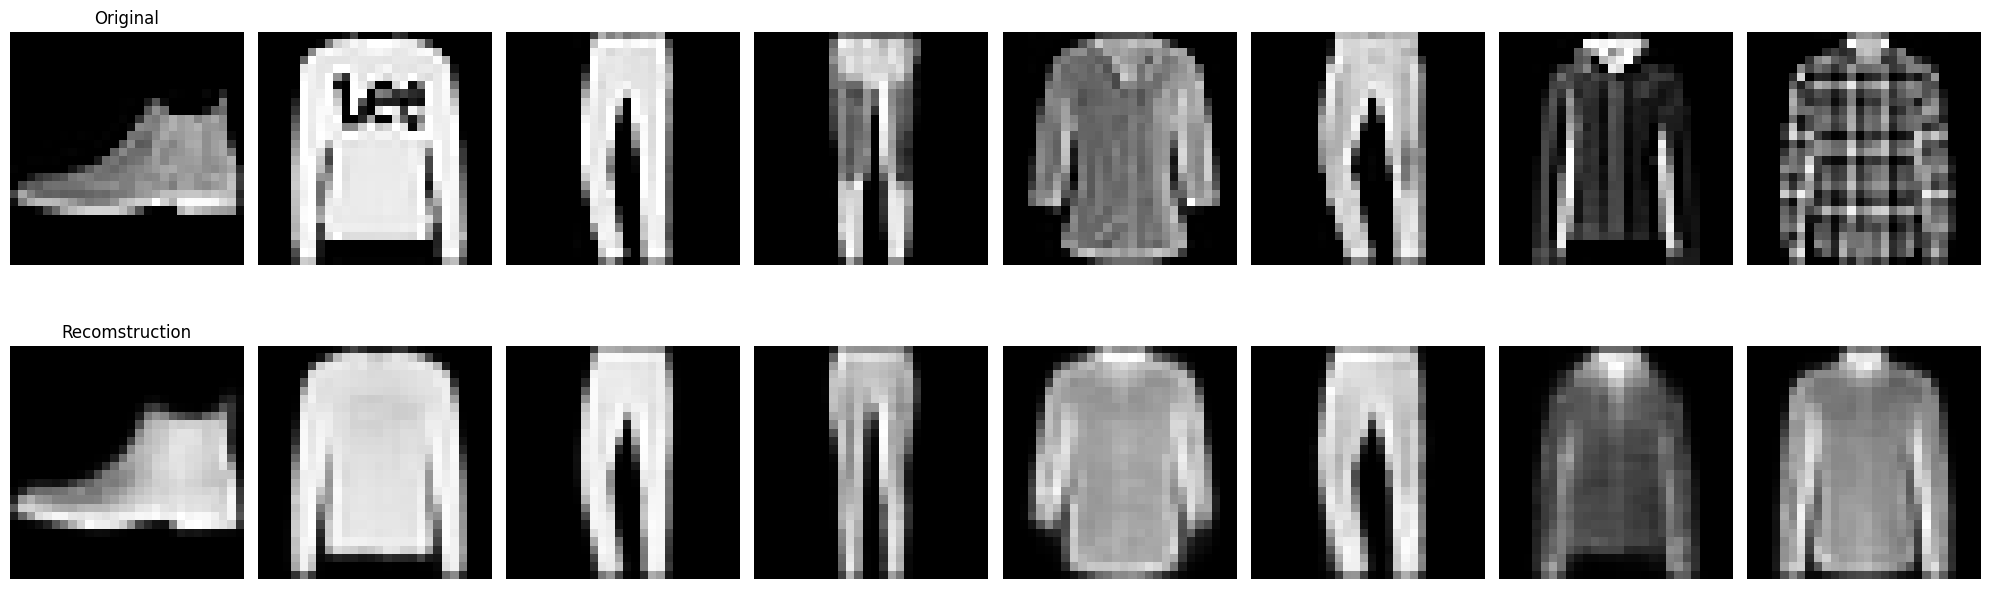

In [ ]:

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))
    
    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')
    
    plt.tight_layout()
    plt.show()


# 1. Récupérer un batch de données de test
batch_images, batch_labels = next(iter(test_loader))

# 2. Sélectionner un échantillon (ex: les 8 premières images)
n_samples = 8
inputs = batch_images[:n_samples].to(device)
labels = batch_labels[:n_samples].to(device)

# 3. Obtenir les reconstructions
cvae.eval() # Mode évaluation (désactive BatchNorm)
with torch.no_grad():
    recons, _, _ = cvae(inputs, labels) #encodage et decodage des 8 images

# 4. Préparation pour l'affichage (CPU + Numpy)
# On passe de [N, 1, 28, 28] à [N, 28, 28] avec squeeze()
original_images = inputs.cpu().numpy().squeeze()
reconstructed_images = recons.cpu().numpy().squeeze()   

image_comparison(original_images, reconstructed_images, n_images=n_samples)



On observe un plutot bonne reconstruction des images même sans optimisation spécifiques des hyperparamètres.

#### B. Visualisation de l'espace latent

Nous affichons seulement les deux premieres dimensions de l'espace latent.

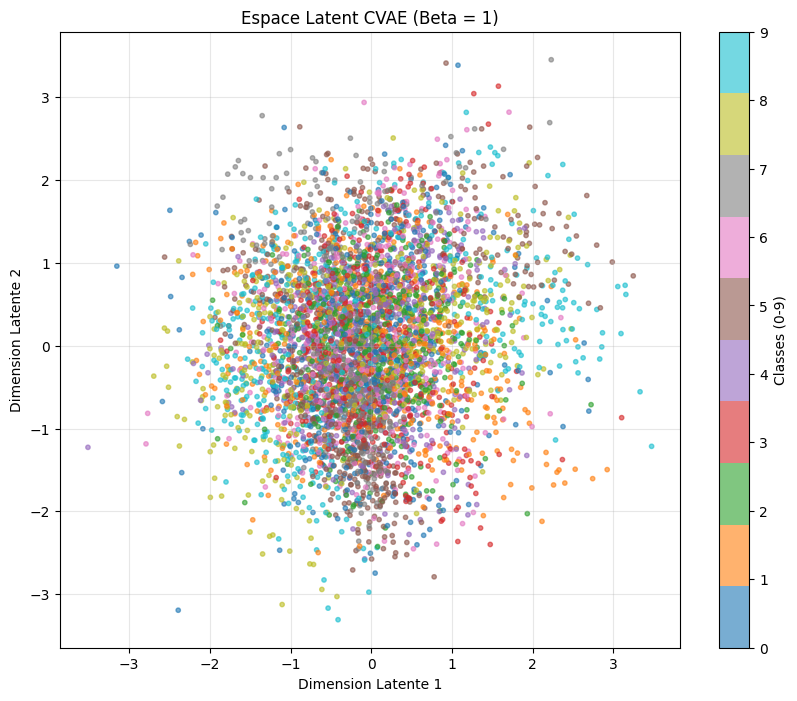

In [12]:

def plot_latent_space(model, beta):
    model.eval()
    with torch.no_grad():
        # On prend un grand lot d'images de test pour bien voir les clusters
        test_loader_viz = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000, shuffle=False)
        data, labels = next(iter(test_loader_viz))
        data, labels = data.to(device), labels.to(device)
        
        # 1. Créer le vecteur One-Hot 'c' manuellement car model.encode() en a besoin
        c = torch.zeros(data.size(0), 10).to(device)
        c.scatter_(1, labels.view(-1, 1), 1)
        
        # 2. Encoder avec l'image ET la condition
        mu, logvar = model.encode(data, c)
        
        # 3. Récupérer les coordonnées (on utilise mu, la moyenne)
        z = mu.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # 4. Affichage
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels_np, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10), label='Classes (0-9)')
        plt.title(f'Espace Latent CVAE (Beta = {beta})')
        plt.xlabel('Dimension Latente 1')
        plt.ylabel('Dimension Latente 2')
        plt.grid(True, alpha=0.3)
        plt.show() #

plot_latent_space(cvae,beta)

Tous les points sont mélangés et c'est normal pour un cvae car on lui donne les étiquettes donc les vetements sont regroupés par style de dessin et non par classe. De plus, notre espace latent a 10 dimensions donc on observe ici qu'une petite partie de ce dernier.

# Génération de 5 nouveaux échantillons (Question 3)

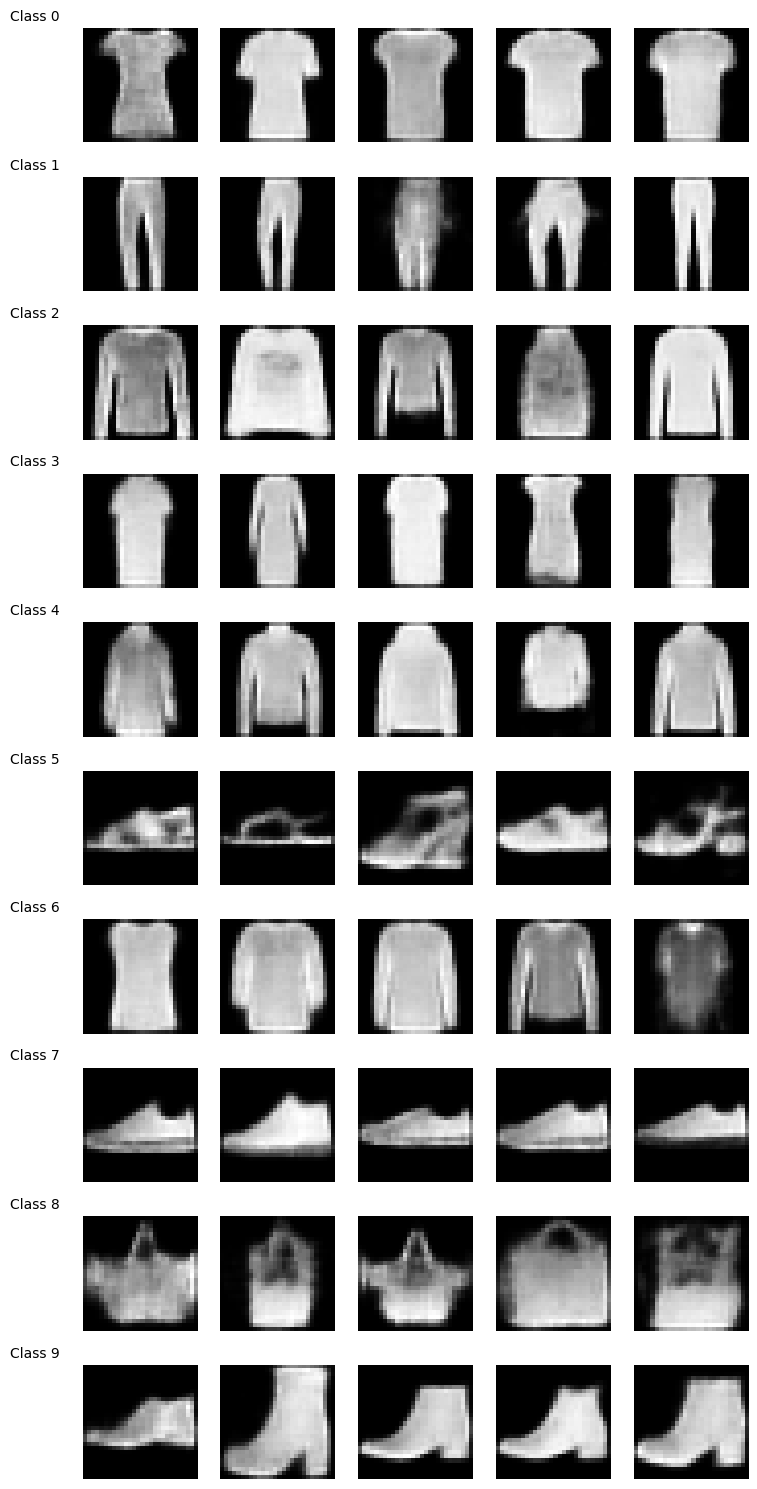

In [13]:
def generate_sample_per_class(num_samples=5):
    cvae.eval()
    num_classes = 10
    
    # On prépare une grille de plots : 10 lignes (classes), 5 colonnes (samples)
    fig, ax = plt.subplots(num_classes, num_samples, figsize=(num_samples * 1.5, num_classes * 1.5))
    
    with torch.no_grad():
        for class_idx in range(num_classes):
            # 1. Sample random latent vectors (z)
            # On génère 'num_samples' vecteurs de bruit
            z = torch.randn(num_samples, cvae.latent_dim).to(device) # z, le bruit, est aléatoire 
            
            # 2. Prepare the Condition (c)
            # On crée les labels pour la classe actuelle (ex: [0, 0, 0, 0, 0] pour la première boucle)
            labels = torch.tensor([class_idx] * num_samples).view(-1, 1).to(device) # on choisit la classe ( quel vetement on veut générer)
            
            # On convertit en One-Hot (nécessaire pour le décodeur du CVAE)
            c = torch.zeros(num_samples, num_classes).to(device)
            c.scatter_(1, labels, 1)
            
            # 3. Decode the latent vectors with the condition
            samples = cvae.decode(z, c)
            
            # Reshape pour l'affichage
            samples = samples.cpu().view(num_samples, 28, 28)

            # 4. Affichage dans la grille
            for i in range(num_samples):
                ax[class_idx, i].imshow(samples[i], cmap='gray')
                ax[class_idx, i].axis('off')
                
                # Ajout du titre seulement sur la première colonne
                if i == 0:
                    ax[class_idx, i].set_title(f"Class {class_idx}", fontsize=10, x=-0.2, ha='right')

    plt.tight_layout()
    plt.show()

# Lancer la génération
generate_sample_per_class(num_samples=5)

### Optimisation des hyperparamètres 

Nous cherchons à optimiser le learning rate, la taille de batch, beta de la fonction de perte.

Pour commencer, on crée un jeu de validation afin de tester nos hyperparamètres.

In [ ]:
# Split test data into validation and test sets, comme dans le tp, attention ne pas run deux fois

val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

On utilise la classe CVAE défnie au début du projet.

Pour l'optimisation, Il n'existe pas de règle absolue, mais la pratique standard en deep learning suit généralement cet ordre de priorité :
1. Définir une architecture de base (Baseline)

Avant d'optimiser, vous devez avoir une architecture cohérente avec la complexité de votre problème.

    Capacité du modèle : Si votre architecture est trop simple (ex: hidden_dim trop petit), le modèle subira un sous-apprentissage (underfitting), peu importe la qualité du learning rate.

    Objectif : Atteindre un niveau de performance minimal où le modèle commence à apprendre (la perte diminue).

2. Optimiser les hyperparamètres critiques (Learning Rate / Batch Size)

C'est l'étape la plus cruciale après avoir fixé l'architecture de base.

    Le Learning Rate (LR) : C'est l'hyperparamètre le plus important. Un mauvais LR empêchera n'importe quelle architecture de converger.

    Le Batch Size : Il influence la stabilité du gradient et la vitesse d'entraînement.

    Méthode : Utilisez un "Learning Rate Finder" ou une recherche aléatoire (Random Search) sur une échelle logarithmique.

3. Ajuster l'architecture (Fine-tuning structurel)

Une fois que vous avez un learning rate stable, vous pouvez affiner la structure :

    Ajouter ou retirer des couches.

    Modifier la dimension du width ou du hidden_dim.

    Ajouter de la régularisation (Dropout, Batch Normalization) si vous observez du sur-apprentissage (overfitting).

4. Itérer

Le processus est cyclique. Si vous changez radicalement l'architecture (ex: doubler le nombre de couches), vous devrez souvent réajuster légèrement le learning rate.
Résumé de la stratégie recommandée

    Architecture : Concevez une structure "raisonnable" (comme celle de votre code).

    Learning Rate : Trouvez la valeur optimale pour cette structure.

    Architecture : Testez des variations de profondeur/largeur pour améliorer les résultats.

    Hyperparamètres : Affinez le reste (poids, batch size, optimiseur).

Conseil technique : Pour un Autoencoder, commencez toujours par vérifier si le modèle peut "overfitter" (mémoriser parfaitement) un très petit échantillon de données (5-10 exemples). Si l'architecture et le learning rate ne permettent pas cela, le problème est structurel ou lié au LR.

In [ ]:
#code pour optimiser les hyperparametres : batch, dim latente, learning rate et beta

import itertools

def hyperparameter_search(train_dataset, val_dataset, device):
    # 1. Définition de la grille de recherche
    param_grid = {
        'latent_dim': [10, 20],
        'beta': [1.0, 5.0],
        'lr': [1e-3, 5e-4],
        'batch_size': [128, 256]
    }
    
    # Génère toutes les combinaisons possibles
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    results = []
    epochs_test = 10 
    
    print(f"Total de combinaisons à tester : {len(combinations)}")
    
    for i, config in enumerate(combinations):
        print(f"\n--- Test {i+1}/{len(combinations)} : {config} ---")
        
        # DataLoader d'entraînement
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True
        )
        
        # DataLoader de validation
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset, 
            batch_size=config['batch_size'], 
            shuffle=False
        )
        
        # Initialisation du modèle et de l'optimiseur
        model = ConvCVAE(latent_dim=config['latent_dim'], num_classes=10).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        
        # Entraînement (sur le train_dataset)
        train_cvae_model(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            epochs=epochs_test,
            beta=config['beta'],
            device=device
        )
        
        # --- Évaluation sur le val_dataset ---
        model.eval()
        val_bce_total = 0
        val_kld_total = 0
        
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                recon, mu, logvar = model(data, labels)
                _, bce, kld = loss_function(recon, data, mu, logvar, config['beta'])
                val_bce_total += bce.item()
                val_kld_total += kld.item()
        
        # Calcul des moyennes par image pour le jeu de validation
        avg_val_bce = val_bce_total / len(val_dataset)
        avg_val_kld = val_kld_total / len(val_dataset)
        
        # Stockage des résultats de validation
        config_results = {
            **config,
            'val_bce': avg_val_bce,
            'val_kld': avg_val_kld,
            'val_total': avg_val_bce + (config['beta'] * avg_val_kld)
        }
        results.append(config_results)
        print(f"Validation Result -> BCE: {avg_val_bce:.2f}, KLD: {avg_val_kld:.2f}")

    return results

# Exécution avec les deux datasets distincts
all_results = hyperparameter_search(train_dataset, val_dataset, device)

Total de combinaisons à tester : 16

--- Test 1/16 : {'latent_dim': 10, 'beta': 1.0, 'lr': 0.001, 'batch_size': 128} ---
Début de l'entraînement : 10 epochs, Beta=1.0
--------------------------------------------------
Epoch [1/10] | Loss: 266.03 | BCE: 253.98 | KLD: 12.05
Epoch [2/10] | Loss: 243.70 | BCE: 231.32 | KLD: 12.38
Epoch [3/10] | Loss: 240.84 | BCE: 228.55 | KLD: 12.29
Epoch [4/10] | Loss: 239.22 | BCE: 226.94 | KLD: 12.27
Epoch [5/10] | Loss: 238.24 | BCE: 225.95 | KLD: 12.28
Epoch [6/10] | Loss: 237.55 | BCE: 225.21 | KLD: 12.34
Epoch [7/10] | Loss: 236.95 | BCE: 224.61 | KLD: 12.34
Epoch [8/10] | Loss: 236.56 | BCE: 224.19 | KLD: 12.37
Epoch [9/10] | Loss: 236.13 | BCE: 223.73 | KLD: 12.39
Epoch [10/10] | Loss: 235.80 | BCE: 223.41 | KLD: 12.39
--------------------------------------------------
Entraînement terminé.

--- Test 2/16 : {'latent_dim': 10, 'beta': 1.0, 'lr': 0.001, 'batch_size': 256} ---
Début de l'entraînement : 10 epochs, Beta=1.0
---------------------------

code Albane sur les hyperparam mais attention pas sur le bon jeu de test (train et non sur validation)

In [ ]:
import itertools

# 1. Définir les paramètres à tester

param_grid = {
    'batch_size': [64, 128],
    'learning_rate': [1e-3, 1e-4],
    'beta': [1.0, 5.0],      # Le poids de la régularisation
 
}

# On crée toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Nombre total de configurations à tester : {len(combinations)}")

# Variables pour sauvegarder le meilleur résultat
best_loss = float('inf')
best_params = {}
results = []

# Boucle principale de recherche
for i, params in enumerate(combinations):
    print(f"\n--- Test {i+1}/{len(combinations)} : {params} ---")
    
    # A. Configuration dynamique
    current_batch_size = params['batch_size']
    current_lr = params['learning_rate']
    current_beta = params['beta']
    current_latent = params['latent_dim']
    
    # Rechargement des DataLoaders avec la bonne batch_size
    train_loader = DataLoader(dataset=train_dataset, batch_size=current_batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=current_batch_size, shuffle=False)
    
    # B. Initialisation du modèle
    model = ConvCVAE(latent_dim=current_latent, num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=current_lr)
    
    # C. Entraînement court (ex: 5 epochs pour tester vite fait)
    # Tu peux augmenter si tu as du temps (ex: 10 ou 20)
    epochs_search = 5 
    
    for epoch in range(epochs_search):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, current_beta)
            loss.backward()
            optimizer.step()
            
    # D. Évaluation sur le Test Set (pour voir si c'est "le meilleur")
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, current_beta)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"--> Test Loss finale : {avg_test_loss:.4f}")
    
    # Sauvegarde des résultats
    results.append({'params': params, 'loss': avg_test_loss})
    
    # Est-ce le meilleur jusqu'à présent ?
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = params
        # Optionnel : Sauvegarder le modèle complet si c'est le meilleur
        # torch.save(model.state_dict(), "best_cvae.pth")

print("\n================ RESULTATS FINAUX ================")
print(f"Meilleure Loss trouvée : {best_loss:.4f}")
print(f"Meilleurs paramètres : {best_params}")

# Afficher le top 3 des configurations
sorted_results = sorted(results, key=lambda x: x['loss'])
print("\nTop 3 Configurations :")
for res in sorted_results[:3]:
    print(res)

Nombre total de configurations à tester : 16

--- Test 1/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 1.0, 'latent_dim': 2} ---
--> Test Loss finale : 254.7504

--- Test 2/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 1.0, 'latent_dim': 10} ---
--> Test Loss finale : 239.1789

--- Test 3/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 5.0, 'latent_dim': 2} ---
--> Test Loss finale : 267.9099

--- Test 4/16 : {'batch_size': 64, 'learning_rate': 0.001, 'beta': 5.0, 'latent_dim': 10} ---
--> Test Loss finale : 265.5215

--- Test 5/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 1.0, 'latent_dim': 2} ---
--> Test Loss finale : 255.7743

--- Test 6/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 1.0, 'latent_dim': 10} ---
--> Test Loss finale : 242.9521

--- Test 7/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta': 5.0, 'latent_dim': 2} ---
--> Test Loss finale : 268.7273

--- Test 8/16 : {'batch_size': 64, 'learning_rate': 0.0001, 'beta'

### test pour l'architecture

--- Lancement de la comparaison d'architecture ---
Paramètres (Modèle Normal): 254917
Paramètres (Modèle Petit): 73893
Entraînement architecture : Normal
Entraînement architecture : Petit


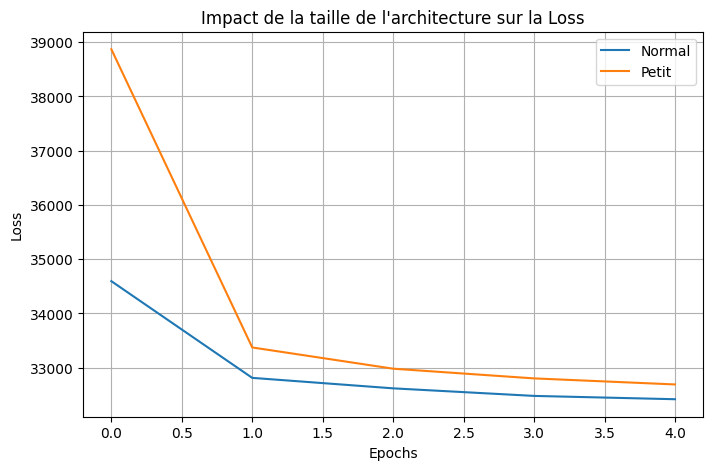

In [12]:
# Partie 1 : Choix de l'Architecture (CORRIGÉ)

class SmallConvCVAE(ConvCVAE):
    def __init__(self, latent_dim=10, num_classes=10):
        # On initialise la classe mère
        super(SmallConvCVAE, self).__init__(latent_dim, num_classes)
        
        # --- ENCODER PLUS PETIT ---
        # On réduit le nombre de filtres de moitié par rapport au modèle original
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + num_classes, 16, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
        )

        # Les couches linéaires doivent correspondre à la sortie (64 * 4 * 4 = 1024)
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)
        
        # --- DECODER PLUS PETIT ---
        self.fc_decode = nn.Linear(latent_dim + num_classes, 64 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    # --- IL FAUT REDEFINIR ENCODE ET DECODE POUR UTILISER "64" ---
    def encode(self, x, c):
        c_expanded = c.view(-1, self.num_classes, 1, 1).expand(-1, -1, 28, 28)
        inputs = torch.cat([x, c_expanded], 1)
        
        x = self.encoder(inputs)
        
        # CORRECTION ICI : 64 au lieu de 128
        x = x.view(-1, 64 * 4 * 4) 
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decode(self, z, c):
        inputs = torch.cat([z, c], 1) 
        x = self.fc_decode(inputs)
        
        # CORRECTION ICI : 64 au lieu de 128
        x = x.view(-1, 64, 4, 4)
        
        x = self.decoder(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Comparaison ---
print("--- Lancement de la comparaison d'architecture ---")
model_normal = ConvCVAE(latent_dim=2).to(device)
model_small = SmallConvCVAE(latent_dim=2).to(device)

print(f"Paramètres (Modèle Normal): {count_parameters(model_normal)}")
print(f"Paramètres (Modèle Petit): {count_parameters(model_small)}")

# Entraînement rapide de comparaison (5 epochs)
models = {'Normal': model_normal, 'Petit': model_small}
losses = {'Normal': [], 'Petit': []}

for name, model in models.items():
    print(f"Entraînement architecture : {name}")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(5): # Tu peux réduire à 3 si c'est trop long
        epoch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=1)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        losses[name].append(epoch_loss / len(train_loader))

# Plot
plt.figure(figsize=(8, 5))
for name, loss_curve in losses.items():
    plt.plot(loss_curve, label=name)
plt.title("Impact de la taille de l'architecture sur la Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Test pour les hyperparamètres 

--- Comparaison des Learning Rates ---
Test avec LR = 0.01
Test avec LR = 0.001
Test avec LR = 0.0001


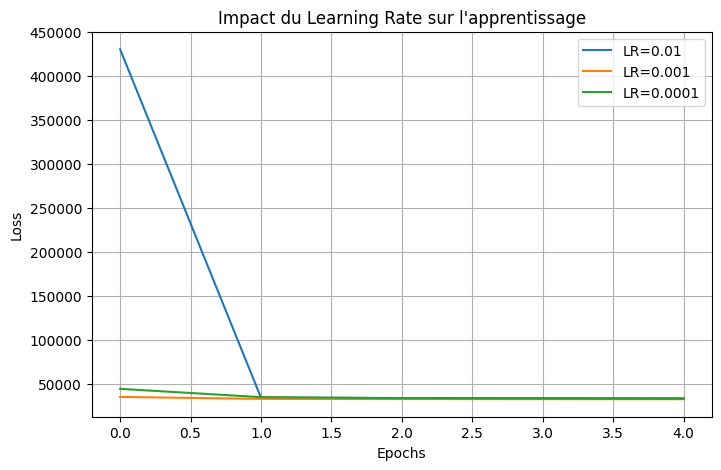

In [13]:
lrs_to_test = [1e-2, 1e-3, 1e-4]
loss_histories = {}

print("--- Comparaison des Learning Rates ---")

for lr in lrs_to_test:
    print(f"Test avec LR = {lr}")
    # Réinitialisation
    cvae_temp = ConvCVAE(latent_dim=2).to(device)
    opt_temp = optim.Adam(cvae_temp.parameters(), lr=lr)
    
    losses = []
    cvae_temp.train()
    
    # On fait juste 5 epochs pour voir la vitesse de convergence
    for epoch in range(5):
        batch_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            opt_temp.zero_grad()
            recon, mu, logvar = cvae_temp(data, labels)
            loss, _, _ = loss_function(recon, data, mu, logvar, beta=1)
            loss.backward()
            opt_temp.step()
            batch_loss += loss.item()
        losses.append(batch_loss / len(train_loader))
    
    loss_histories[str(lr)] = losses

# Plot
plt.figure(figsize=(8, 5))
for lr, loss_curve in loss_histories.items():
    plt.plot(loss_curve, label=f"LR={lr}")
plt.title("Impact du Learning Rate sur l'apprentissage")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### choix de la fonction perte

--- Analyse des composantes de la Loss ---


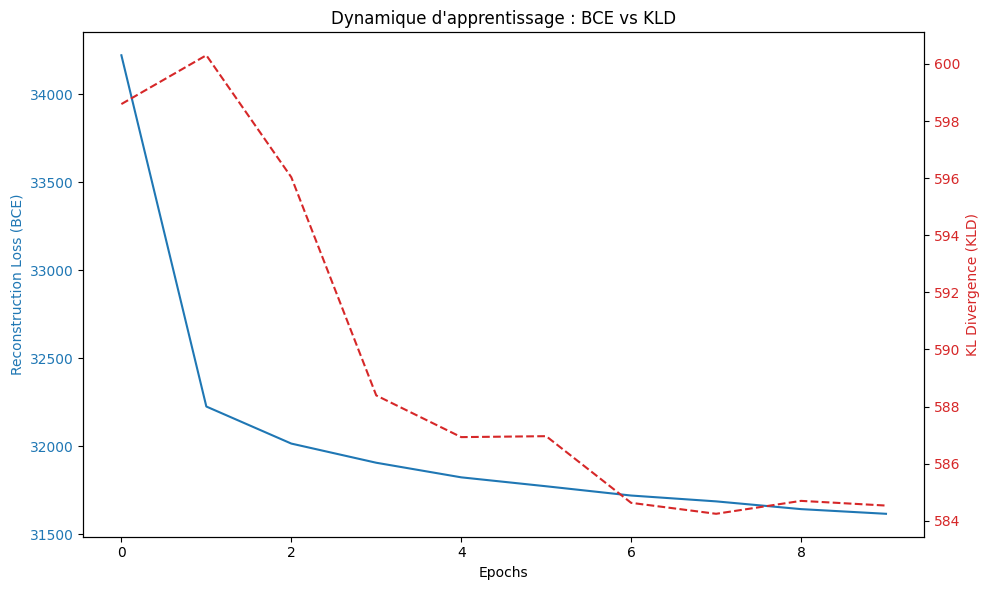

In [14]:
# On reprend ton modèle standard
final_model = ConvCVAE(latent_dim=2).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

history_bce = []
history_kld = []
epochs_loss = 10 # Suffisant pour voir la dynamique

print("--- Analyse des composantes de la Loss ---")

for epoch in range(epochs_loss):
    final_model.train()
    epoch_bce = 0
    epoch_kld = 0
    
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = final_model(data, labels)
        
        # On récupère les composants séparés
        loss, bce, kld = loss_function(recon, data, mu, logvar, beta=1)
        
        loss.backward()
        optimizer.step()
        
        epoch_bce += bce.item()
        epoch_kld += kld.item()
        
    history_bce.append(epoch_bce / len(train_loader))
    history_kld.append(epoch_kld / len(train_loader))

# Plot avec deux échelles (car BCE est très grand et KLD très petit)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Reconstruction Loss (BCE)', color=color)
ax1.plot(history_bce, color=color, label='BCE (Qualité Image)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instancier un deuxième axe y
color = 'tab:red'
ax2.set_ylabel('KL Divergence (KLD)', color=color)
ax2.plot(history_kld, color=color, linestyle='--', label='KLD (Régularisation)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Dynamique d'apprentissage : BCE vs KLD")
fig.tight_layout()
plt.show()